# Person attributes recognition with OpenVINO

This tutorial demonstrates person attributes recognition with MidasNet in OpenVINO. Model information can be found [here](https://docs.openvino.ai/latest/omz_models_model_person_attributes_recognition_crossroad_0230.html)

  ![1](./data/1.png)![2](./data/2.png)

### Description

This model presents a person attributes classification algorithm analysis scenario. It produces probability of person attributions existing on the sample and a position of two point on sample, which can be used for color prob (like, color picker in graphical editors)

In [1]:
model_name = "person-attributes-recognition-crossroad-0230"

## Preparation
### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import cv2
from pathlib import Path
from openvino.runtime import Core

sys.path.append("../utils")
from notebook_utils import DeviceNotFoundAlert, NotebookAlert, load_image

### Settings

In [3]:
base_model_dir = Path("./model/open_model_zoo_models").expanduser()
omz_cache_dir = Path("./model/open_model_zoo_cache").expanduser()
model_dir = Path("./model").expanduser()
precision = "FP16"

# Check if an iGPU is available on this system to use with Benchmark App
ie = Core()
gpu_available = "GPU" in ie.available_devices

print(
    f"base_model_dir: {base_model_dir}, omz_cache_dir: {omz_cache_dir}, gpu_availble: {gpu_available}"
)

base_model_dir: model/open_model_zoo_models, omz_cache_dir: model/open_model_zoo_cache, gpu_availble: False


### Dwonload models

In [4]:
#No need for convert !
path_to_model_weights = Path(f'{base_model_dir}/intel/{model_name}/{precision}/{model_name}.bin')
print(path_to_model_weights)
if not path_to_model_weights.is_file():
    download_command = (f"omz_downloader --name {model_name} --output_dir {base_model_dir} --cache_dir {omz_cache_dir}")
    print(download_command)
    ! $download_command
else:
    print("Model has been download")

model/open_model_zoo_models/intel/person-attributes-recognition-crossroad-0230/FP16/person-attributes-recognition-crossroad-0230.bin
Model has been download


### Load the Model

In [5]:
ie = Core()
path_to_model = path_to_model_weights.with_suffix(".xml")
print(f"{path_to_model} is the model's path")

model = ie.read_model(model=path_to_model)
compiled_model = ie.compile_model(model=model, device_name="CPU")
recognition_output_layer = next(iter(compiled_model.outputs))
recognition_input_layer = next(iter(compiled_model.inputs))

print(f"{recognition_output_layer.shape} is output layer's shape")
print(f"{recognition_input_layer.shape} is input layer's shape")

model/open_model_zoo_models/intel/person-attributes-recognition-crossroad-0230/FP16/person-attributes-recognition-crossroad-0230.xml is the model's path
{1, 8, 1, 1} is output layer's shape
{1, 3, 160, 80} is input layer's shape


## Load image

This step loads the image and converts it to the input size

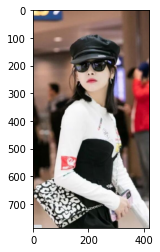

In [6]:
# image_file can point to a URL or local image
image_file = "./data/singerstar.jpg"

# mark some attributes
attrs = ['is_male', 'has_bag', 'has_backpack', 'has_hat', 'has_longsleeves', 'has_longpants', 'has_longhair', 'has_coat_jacket']

image = load_image(image_file)

# N,C,H,W = batch size, number of channels, height, width
N, C, H, W = recognition_input_layer.shape

# Resize image to meet network expected input sizes
resized_image = cv2.resize(image, (W, H))

# Reshape to network input shape
input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)

output_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB);

plt.imshow(output_image);

## Do inference

In [7]:
# use the model to inference
result = compiled_model([input_image])[recognition_output_layer]

# Use different colors to indicate whether the target has the attribute
has_attr = (0,255,255);
no_attr = (255,0,255);
#attribute text height
text_height = 50

#there are 8 attributes, put the 8 attributes text into the picture with different color
for index in range(8):
    # print(type(result[0][index]))
    if result[0][index] > 0.5:
        color = has_attr
    else:
        color = no_attr
    cv2.putText(output_image,attrs[index],(120,text_height),cv2.FONT_HERSHEY_COMPLEX,1,color,2)
    text_height += 50

## Show the result picture

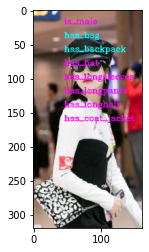

In [8]:
output_image = cv2.resize(output_image, (W * 2, H * 2))
plt.imshow(output_image);

# Delete the downloaded model

The purpose of this block is to clear the downloaded Intel model.

When you are done with the above code and no longer need it, you can run the code below

In [9]:
# import shutil
# import os
# # remove model directory
# if os.path.exists(model_dir):
#     shutil.rmtree(model_dir) 
#     print('{} dir has been removed'.format(model_dir))
# else:
#     print('{} dir is not exist'.format(model_dir))